# **Unsupervised Learning Project: Energy & Sustainability**

# Energy & Sustainability Patterns in Ohio

## Project Overview
This notebook explores energy production, infrastructure, and sustainability-related patterns across Ohio using publicly available data. The goal is to understand how different energy characteristics cluster together and what structural patterns emerge across facilities and regions.

Rather than focusing on prediction, this analysis emphasizes exploratory data analysis and unsupervised learning to surface hidden structure in the data.

## Analytical Goals
The primary objectives of this analysis are to:
- Explore the distribution and scale of key energy-related variables
- Identify similarities and differences across energy facilities
- Examine whether meaningful groupings emerge from the data
- Use dimensionality reduction techniques to support interpretation and visualization

## Methods Used
The analysis follows a structured workflow including:
- Exploratory Data Analysis (EDA)
- Feature scaling and preprocessing
- Clustering (K-Means, K-Medoids, Hierarchical)
- Dimensionality Reduction (PCA, t-SNE)
- Cluster evaluation using internal metrics

## Notes on Scope
This is an exploratory analysis. Findings are intended to highlight patterns and raise questions for further investigation rather than make causal or policy claims.


In [524]:
!pip install numpy==1.26.0

In [525]:
!pip install scikit-learn-extra

In [526]:
!pip -q install geopandas pyogrio shapely

## **Importing the necessary libraries and overview of the dataset**

In [527]:
# Core numerical & data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Preprocessing & dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

# Distance & hierarchical clustering
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Utilities
from IPython.display import display, HTML
import pprint

# Colab / Drive (only keep if you are running in Colab)
from google.colab import drive

# --------------------------------------------------------------------

sns.set_theme(style='darkgrid')

# Remove the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Set the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

import geopandas as gpd


In [528]:
url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
us_counties = gpd.read_file(url)

# Filter the US counties GeoDataFrame to Ohio
ohio_map = us_counties[us_counties["STATE"] == "39"].copy()


## Data Loading & Initial Data Checks
Before merging or modeling, we inspect structure (rows/columns), column types, missing values, and potential duplicates to understand and verify the data loaded correctly.


In [529]:
drive.mount('/content/drive')
path_1 = '/content/drive/MyDrive/Colab Notebooks/Python for Data Science/Unsupervised Learning Practice Project/Energy & Sustainability Project/EIA923_Schedules_2_3_4_5_M_12_2024_Final.xlsx'
path_2 = '/content/drive/MyDrive/Colab Notebooks/Python for Data Science/Unsupervised Learning Practice Project/Energy & Sustainability Project/2___Plant_Y2024.xlsx'

# read the data
df1 = pd.read_excel(path_1, sheet_name=0, header= 5)
df2 = pd.read_excel(path_2, sheet_name=0, header = 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [530]:
# --- Quick look ---
display(df1.head(3))
display(df2.head(3))

# --- Dimensions ---
print(f"df1: {df1.shape[0]:,} rows × {df1.shape[1]:,} columns")
print(f"df2: {df2.shape[0]:,} rows × {df2.shape[1]:,} columns")



,Plant Id,Combined Heat And\nPower Plant,Nuclear Unit Id,Plant Name,Operator Name,Operator Id,Plant State,Census Region,NERC Region,Reserved,NAICS Code,EIA Sector Number,Sector Name,Reported\nPrime Mover,Reported\nFuel Type Code,MER\nFuel Type Code,Balancing\nAuthority Code,Respondent\nFrequency,Physical\nUnit Label,Quantity\nJanuary,Quantity\nFebruary,Quantity\nMarch,Quantity\nApril,Quantity\nMay,Quantity\nJune,Quantity\nJuly,Quantity\nAugust,Quantity\nSeptember,Quantity\nOctober,Quantity\nNovember,Quantity\nDecember,Elec_Quantity\nJanuary,Elec_Quantity\nFebruary,Elec_Quantity\nMarch,Elec_Quantity\nApril,Elec_Quantity\nMay,Elec_Quantity\nJune,Elec_Quantity\nJuly,Elec_Quantity\nAugust,Elec_Quantity\nSeptember,Elec_Quantity\nOctober,Elec_Quantity\nNovember,Elec_Quantity\nDecember,MMBtuPer_Unit\nJanuary,MMBtuPer_Unit\nFebruary,MMBtuPer_Unit\nMarch,MMBtuPer_Unit\nApril,MMBtuPer_Unit\nMay,MMBtuPer_Unit\nJune,MMBtuPer_Unit\nJuly,MMBtuPer_Unit\nAugust,MMBtuPer_Unit\nSeptember,MMBtuPer_Unit\nOctober,MMBtuPer_Unit\nNovember,MMBtuPer_Unit\nDecember,Tot_MMBtu\nJanuary,Tot_MMBtu\nFebruary,Tot_MMBtu\nMarch,Tot_MMBtu\nApril,Tot_MMBtu\nMay,Tot_MMBtu\nJune,Tot_MMBtu\nJuly,Tot_MMBtu\nAugust,Tot_MMBtu\nSeptember,Tot_MMBtu\nOctober,Tot_MMBtu\nNovember,Tot_MMBtu\nDecember,Elec_MMBtu\nJanuary,Elec_MMBtu\nFebruary,Elec_MMBtu\nMarch,Elec_MMBtu\nApril,Elec_MMBtu\nMay,Elec_MMBtu\nJune,Elec_MMBtu\nJuly,Elec_MMBtu\nAugust,Elec_MMBtu\nSeptember,Elec_MMBtu\nOctober,Elec_MMBtu\nNovember,Elec_MMBtu\nDecember,Netgen\nJanuary,Netgen\nFebruary,Netgen\nMarch,Netgen\nApril,Netgen\nMay,Netgen\nJune,Netgen\nJuly,Netgen\nAugust,Netgen\nSeptember,Netgen\nOctober,Netgen\nNovember,Netgen\nDecember,Total Fuel Consumption\nQuantity,Electric Fuel Consumption\nQuantity,Total Fuel Consumption\nMMBtu,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),YEAR
0,1,Y,.,Sand Point,"Sand Point Generating, LLC",63560,AK,PACN,NaN,NaN,22,1,Electric Utility,IC,DFO,DFO,NaN,A,barrels,554,499,601,633,371,663,389,561,373,592,579,492,554,499,601,633,371,663,389,561,373,592,579,492,6.2,6.2,6.2,6.2,6.2,6.2,6.2,6.2,6.2,6.2,6.2,6.2,3435,3094,3726,3925,2300,4111,2412,3478,2313,3670,3590,3050,3435,3094,3726,3925,2300,4111,2412,3478,2313,3670,3590,3050,317.488,285.899,344.581,363.036,212.818,379.954,222.883,321.858,213.754,339.384,332.004,282.341,6307,6307,39104,39104,3616.0,2024
1,1,Y,.,Sand Point,"Sand Point Generating, LLC",63560,AK,PACN,NaN,NaN,22,1,Electric Utility,WT,WND,WND,NaN,AM,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2024
2,2,N,.,Bankhead Dam,Alabama Power Co,195,AL,ESC,SERC,NaN,22,1,Electric Utility,HY,WAT,HYC,SOCO,AM,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61198,81062,66831,42698,12546,2313,12717,1675,38139,2272,13423,33100,61198,81062,66831,42698,12546,2313,12717,1675,38139,2272,13423,33100,17936,23758,19587,12514,3677,678,3727,491,11178,666,3934,9701,0,0,367974,367974,107847.0,2024


,Utility ID,Utility Name,Plant Code,Plant Name,Street Address,City,State,Zip,County,Latitude,Longitude,NERC Region,Balancing Authority Code,Balancing Authority Name,Name of Water Source,Primary Purpose (NAICS Code),Regulatory Status,Sector,Sector Name,FERC Cogeneration Status,FERC Cogeneration Docket Number,FERC Small Power Producer Status,FERC Small Power Producer Docket Number,FERC Exempt Wholesale Generator Status,FERC Exempt Wholesale Generator Docket Number,Ash Impoundment?,Ash Impoundment Lined?,Ash Impoundment Status,Transmission or Distribution System Owner,Transmission or Distribution System Owner ID,Transmission or Distribution System Owner State,Grid Voltage (kV),Grid Voltage 2 (kV),Grid Voltage 3 (kV),Energy Storage,Natural Gas LDC Name,Natural Gas Pipeline Name 1,Natural Gas Pipeline Name 2,Natural Gas Pipeline Name 3,Pipeline Notes,Natural Gas Storage,Liquefied Natural Gas Storage
0,63560,"Sand Point Generating, LLC",1,Sand Point,100 Power Plant Way,Sand Point,AK,99661,Aleutians East,55.339722,-160.497222,NaN,NaN,NaN,NaN,22,RE,1,Electric Utility,N,NaN,N,NaN,N,NaN,N,X,NaN,"TDX Sand Point Generating, LLC",63560,AK,0.48,,,N,NaN,NaN,NaN,NaN,NaN,N,X
1,195,Alabama Power Co,2,Bankhead Dam,19001 Lock 17 Road,Northport,AL,35476,Tuscaloosa,33.458665,-87.356823,SERC,SOCO,"Southern Company Services, Inc. - Trans",Black Warrior River,22,RE,1,Electric Utility,N,NaN,N,NaN,N,NaN,N,X,NaN,Alabama Power Co,195,AL,115,,,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195,Alabama Power Co,3,Barry,North Highway 43,Bucks,AL,36512,Mobile,31.0069,-88.0103,SERC,SOCO,"Southern Company Services, Inc. - Trans",Mobile River,22,RE,1,Electric Utility,N,NaN,N,NaN,N,NaN,Y,N,OP,Alabama Power Co,195,AL,230,,,N,NaN,BAY GAS STORAGE,NaN,NaN,NaN,N,X


df1: 17,964 rows × 97 columns
df2: 16,132 rows × 42 columns


In [531]:
# --- Random samples ---
display(df1.sample(3, random_state=1))
display(df2.sample(3, random_state=1))

,Plant Id,Combined Heat And\nPower Plant,Nuclear Unit Id,Plant Name,Operator Name,Operator Id,Plant State,Census Region,NERC Region,Reserved,NAICS Code,EIA Sector Number,Sector Name,Reported\nPrime Mover,Reported\nFuel Type Code,MER\nFuel Type Code,Balancing\nAuthority Code,Respondent\nFrequency,Physical\nUnit Label,Quantity\nJanuary,Quantity\nFebruary,Quantity\nMarch,Quantity\nApril,Quantity\nMay,Quantity\nJune,Quantity\nJuly,Quantity\nAugust,Quantity\nSeptember,Quantity\nOctober,Quantity\nNovember,Quantity\nDecember,Elec_Quantity\nJanuary,Elec_Quantity\nFebruary,Elec_Quantity\nMarch,Elec_Quantity\nApril,Elec_Quantity\nMay,Elec_Quantity\nJune,Elec_Quantity\nJuly,Elec_Quantity\nAugust,Elec_Quantity\nSeptember,Elec_Quantity\nOctober,Elec_Quantity\nNovember,Elec_Quantity\nDecember,MMBtuPer_Unit\nJanuary,MMBtuPer_Unit\nFebruary,MMBtuPer_Unit\nMarch,MMBtuPer_Unit\nApril,MMBtuPer_Unit\nMay,MMBtuPer_Unit\nJune,MMBtuPer_Unit\nJuly,MMBtuPer_Unit\nAugust,MMBtuPer_Unit\nSeptember,MMBtuPer_Unit\nOctober,MMBtuPer_Unit\nNovember,MMBtuPer_Unit\nDecember,Tot_MMBtu\nJanuary,Tot_MMBtu\nFebruary,Tot_MMBtu\nMarch,Tot_MMBtu\nApril,Tot_MMBtu\nMay,Tot_MMBtu\nJune,Tot_MMBtu\nJuly,Tot_MMBtu\nAugust,Tot_MMBtu\nSeptember,Tot_MMBtu\nOctober,Tot_MMBtu\nNovember,Tot_MMBtu\nDecember,Elec_MMBtu\nJanuary,Elec_MMBtu\nFebruary,Elec_MMBtu\nMarch,Elec_MMBtu\nApril,Elec_MMBtu\nMay,Elec_MMBtu\nJune,Elec_MMBtu\nJuly,Elec_MMBtu\nAugust,Elec_MMBtu\nSeptember,Elec_MMBtu\nOctober,Elec_MMBtu\nNovember,Elec_MMBtu\nDecember,Netgen\nJanuary,Netgen\nFebruary,Netgen\nMarch,Netgen\nApril,Netgen\nMay,Netgen\nJune,Netgen\nJuly,Netgen\nAugust,Netgen\nSeptember,Netgen\nOctober,Netgen\nNovember,Netgen\nDecember,Total Fuel Consumption\nQuantity,Electric Fuel Consumption\nQuantity,Total Fuel Consumption\nMMBtu,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),YEAR
3315,6484,N,.,Bend,PacifiCorp,14354,OR,PACC,WECC,NaN,22,1,Electric Utility,HY,WAT,HYC,PACW,AM,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,201,78,566,768,901,485,259,300,208,0,0,0,201,78,566,768,901,485,259,300,208,0,0,-1,59,23,166,225,264,142,76,88,61,-1,-1,0,0,3766,3766,1101.000,2024
11001,60151,N,.,Building F,Golden Springs Development Company LLC,57104,CA,PACC,WECC,NaN,22,2,NAICS-22 Non-Cogen,PV,SUN,SUN,CISO,AM,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,481,447,693,768,757,850,945,908,689,583,481,252,481,447,693,768,757,850,945,908,689,583,481,252,141,131,203,225,222,249,277,266,202,171,141,74,0,0,7854,7854,2302.000,2024
6411,54780,Y,.,University of Illinois Abbott Power Plt,University of Illinois,19528,IL,ENC,SERC,NaN,611,5,Commercial NAICS Cogen,ST,NG,NG,MISO,AM,mcf,186666,151421,151890,122420,127951,103276,110310,110042,69179,87458,174843,198628,27503,25483,38503,37634,33045,39279,43129,43954,27006,22711,23426,32159,1.03,1.03,1.03,1.03,1.03,1.03,1.03,1.03,1.03,1.03,1.03,1.03,192266,155964,156447,126093,131790,106374,113619,113343,71254,90082,180088,204587,28328,26248,39658,38763,34036,40457,44423,45273,27816,23392,24129,33124,4717.518,4371.098,6604.272,6455.232,5668.122,6737.474,7397.901,7539.488,4632.304,3895.495,4018.269,5516.29,1594084,393832,1641907,405647,67553.463,2024


,Utility ID,Utility Name,Plant Code,Plant Name,Street Address,City,State,Zip,County,Latitude,Longitude,NERC Region,Balancing Authority Code,Balancing Authority Name,Name of Water Source,Primary Purpose (NAICS Code),Regulatory Status,Sector,Sector Name,FERC Cogeneration Status,FERC Cogeneration Docket Number,FERC Small Power Producer Status,FERC Small Power Producer Docket Number,FERC Exempt Wholesale Generator Status,FERC Exempt Wholesale Generator Docket Number,Ash Impoundment?,Ash Impoundment Lined?,Ash Impoundment Status,Transmission or Distribution System Owner,Transmission or Distribution System Owner ID,Transmission or Distribution System Owner State,Grid Voltage (kV),Grid Voltage 2 (kV),Grid Voltage 3 (kV),Energy Storage,Natural Gas LDC Name,Natural Gas Pipeline Name 1,Natural Gas Pipeline Name 2,Natural Gas Pipeline Name 3,Pipeline Notes,Natural Gas Storage,Liquefied Natural Gas Storage
11968,64282,"LeConte Energy Storage, LLC",64701,LeConte Energy Storage,1561 W. Highway 98,Calexico,CA,92231,Imperial,32.677208,-115.670203,WECC,CISO,California Independent System Operator,NaN,22,NR,2,IPP Non-CHP,N,NaN,N,NaN,N,NaN,N,X,NaN,San Diego Gas & Electric Co,16609,CA,230,,,Y,NaN,NaN,NaN,NaN,NaN,N,X
5816,67036,NW Stadium Solar Plant,57747,FedEx Field Solar Facility,1600 FedEx Way,Landover,MD,20785,Prince Georges,38.907778,-76.864444,RFC,PJM,"PJM Interconnection, LLC",NaN,22,NR,2,IPP Non-CHP,N,NaN,Y,11-469,N,NaN,N,X,NaN,Potomac Electric Power Co,15270,MD,48,,,N,NaN,NaN,NaN,NaN,NaN,X,X
5657,17609,Southern California Edison Co,57543,Solar Photovoltaic Project #47,2211 E Carson Street,Carson,CA,90810,Los Angeles,33.703546,-117.915352,WECC,CISO,California Independent System Operator,NaN,22,RE,1,Electric Utility,N,NaN,N,NaN,N,NaN,NaN,X,NaN,Southern California Edison Co,17609,CA,12,,,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [532]:
# --- Data types + non-null counts ---
print("\ndf1 info:")
df1.info()


df1 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17964 entries, 0 to 17963
Data columns (total 97 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Plant Id                            17964 non-null  int64  
 1   Combined Heat And
Power Plant       17964 non-null  object 
 2   Nuclear Unit Id                     17964 non-null  object 
 3   Plant Name                          17963 non-null  object 
 4   Operator Name                       17963 non-null  object 
 5   Operator Id                         17964 non-null  object 
 6   Plant State                         17963 non-null  object 
 7   Census Region                       17964 non-null  object 
 8   NERC Region                         16942 non-null  object 
 9   Reserved                            0 non-null      float64
 10  NAICS Code                          17964 non-null  int64  
 11  EIA Sector Number             

In [533]:
print("\ndf2 info:")
df2.info()


df2 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16132 entries, 0 to 16131
Data columns (total 42 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   Utility ID                                       16132 non-null  int64 
 1   Utility Name                                     16132 non-null  object
 2   Plant Code                                       16132 non-null  int64 
 3   Plant Name                                       16132 non-null  object
 4   Street Address                                   16011 non-null  object
 5   City                                             16096 non-null  object
 6   State                                            16132 non-null  object
 7   Zip                                              16132 non-null  object
 8   County                                           16108 non-null  object
 9   Latitude                    

In [534]:
# --- Missing values (top contributors) ---
missing_df1 = df1.isna().mean().sort_values(ascending=False)
missing_df2 = df2.isna().mean().sort_values(ascending=False)

print("\nTop missing (df1):")
display((missing_df1[missing_df1 > 0] * 100).head(15).to_frame("% missing"))

print("\nTop missing (df2):")
display((missing_df2[missing_df2 > 0] * 100).head(15).to_frame("% missing"))

# --- Duplicate rows ---
print("\nDuplicate rows:")
print("df1 duplicates:", df1.duplicated().sum())
print("df2 duplicates:", df2.duplicated().sum())


Top missing (df1):


,% missing
Reserved,100.000000
Physical\nUnit Label,52.621910
NERC Region,5.689156
Balancing\nAuthority Code,2.148742
Respondent\nFrequency,1.491873
Operator Name,0.005567
Plant State,0.005567
Plant Name,0.005567



Top missing (df2):


,% missing
Natural Gas Pipeline Name 3,99.659063
Natural Gas Pipeline Name 2,98.605257
Pipeline Notes,98.431689
Ash Impoundment Status,98.034962
FERC Cogeneration Docket Number,97.229110
Natural Gas Pipeline Name 1,91.086040
FERC Exempt Wholesale Generator Docket Number,90.577734
Natural Gas LDC Name,90.422762
Name of Water Source,73.208530
FERC Small Power Producer Docket Number,70.654600



Duplicate rows:
df1 duplicates: 0
df2 duplicates: 0


## Data Preparation & Merge Strategy

We combine:
- **EIA-923 generation data (df1)**: plant-level generation values by fuel type
- **EIA-860 plant metadata (df2)**: plant location fields (State, County)

Merge key:
- `df1['Plant Id']` ↔ `df2['Plant Code']`

Before merging, we standardize key formats and verify whether `Plant Code` is unique in the metadata table.

We keep only the columns needed for:
- Joining generation records to plant metadata (Plant Id ↔ Plant Code)
- Filtering to Ohio (Plant State)
- Quantifying output (Net Generation)
- Stratifying by fuel type (MER Fuel Type Code)

This keeps the workflow focused and reduces noise during checks and merging.



In [535]:
display(df1[['Plant Id', 'Plant Name']].head())
display(df2[['Plant Code', 'Plant Name', 'State', 'County']].head())


,Plant Id,Plant Name
0,1,Sand Point
1,1,Sand Point
2,2,Bankhead Dam
3,3,Barry
4,3,Barry


,Plant Code,Plant Name,State,County
0,1,Sand Point,AK,Aleutians East
1,2,Bankhead Dam,AL,Tuscaloosa
2,3,Barry,AL,Mobile
3,4,Walter Bouldin Dam,AL,Elmore
4,7,Gadsden,AL,Etowah


In [536]:
# Keeping only the columns we need
df1_sub = df1[['Plant Id', 'Plant State', 'MER\nFuel Type Code', 'Net Generation\n(Megawatthours)']].copy()
df2_sub = df2[['Plant Code', 'State', 'County']].copy()

df1_sub.info(), df2_sub.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17964 entries, 0 to 17963
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Plant Id                        17964 non-null  int64  
 1   Plant State                     17963 non-null  object 
 2   MER
Fuel Type Code              17964 non-null  object 
 3   Net Generation
(Megawatthours)  17964 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 561.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16132 entries, 0 to 16131
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Plant Code  16132 non-null  int64 
 1   State       16132 non-null  object
 2   County      16108 non-null  object
dtypes: int64(1), object(2)
memory usage: 378.2+ KB


(None, None)

In [537]:
print("Missing Plant Id in df1_sub:", df1_sub['Plant Id'].isna().sum())
print("Missing Plant Code in df2_sub:", df2_sub['Plant Code'].isna().sum())


Missing Plant Id in df1_sub: 0
Missing Plant Code in df2_sub: 0


### Validate metadata uniqueness

Plant metadata should ideally be one row per plant (`Plant Code`).
If duplicates exist in the metadata table, a merge can unintentionally become many-to-many and inflate the dataset.
We check this explicitly before merging.


In [538]:
dup_codes = df2_sub['Plant Code'].duplicated().sum()
print("Duplicate Plant Codes in df2_sub:", dup_codes)

if dup_codes > 0:
    display(df2_sub[df2_sub['Plant Code'].duplicated(keep=False)].sort_values('Plant Code').head(10))


Duplicate Plant Codes in df2_sub: 0


### Merge generation data with plant metadata

We perform a left join so that all generation records remain in the dataset.

In [539]:
# Merging generation data with county information

merged = pd.merge(
    df1_sub,
    df2_sub,
    left_on='Plant Id',
    right_on='Plant Code',
    how='left',
    validate='m:1',
    indicator=True
)

print("Rows before merge:", len(df1_sub))
print("Rows after merge:", len(merged))
print("Merge indicator counts:")
print(merged['_merge'].value_counts())

print("Missing County:", merged['County'].isna().sum())


Rows before merge: 17964
Rows after merge: 17964
Merge indicator counts:
_merge
both          17626
left_only       338
right_only        0
Name: count, dtype: int64
Missing County: 338


**Merge check summary**

The merge preserves all generation records and does not introduce duplicate rows.
A total of 338 generation rows do not match plant metadata, which corresponds exactly to the number of missing county values.
These unmatched records will be reassessed after filtering to Ohio.


In [540]:
merged = merged.rename(columns={
    'Plant Id': 'plant_id',
    'Plant State': 'plant_state',
    'MER\nFuel Type Code': 'fuel_code',
    'Net Generation\n(Megawatthours)': 'net_generation_mwh',
    'Plant Code': 'plant_code',
    'State': 'state',
    'County': 'county'
})

display(merged.sample(3, random_state=1))

,plant_id,plant_state,fuel_code,net_generation_mwh,plant_code,state,county,_merge
3315,6484,OR,HYC,1101.000,6484.0,OR,Deschutes,both
11001,60151,CA,SUN,2302.000,60151.0,CA,Los Angeles,both
6411,54780,IL,NG,67553.463,54780.0,IL,Champaign,both


## Ohio Subset

The focus of this analysis is Ohio.  
We therefore restrict the merged dataset to plants reported in Ohio before proceeding with exploratory analysis.


In [541]:
oh = merged[merged['plant_state'] == 'OH'].copy()

print("Total Ohio rows:", len(oh))
print("Unique Ohio plants:", oh['plant_id'].nunique())
print("Missing county values in Ohio:", oh['county'].isna().sum())
print("\nFuel codes in Ohio (top 15):")
display(oh['fuel_code'].value_counts().head(5))
display(oh['fuel_code'].value_counts().tail(5))

Total Ohio rows: 304
Unique Ohio plants: 198
Missing county values in Ohio: 13

Fuel codes in Ohio (top 15):


,count
fuel_code,
NG,80
DFO,72
SUN,60
COL,27
WND,23


,count
fuel_code,
ORW,5
PC,2
NUC,2
WOO,1
WOC,1


Ohio contains multiple generation records per plant, reflecting different fuel types or reporting entries.

A small number of Ohio records lack county information, which will be handled explicitly during aggregation.


## Fuel Mix in Ohio

We begin by examining total net generation by fuel type to understand Ohio’s energy composition.


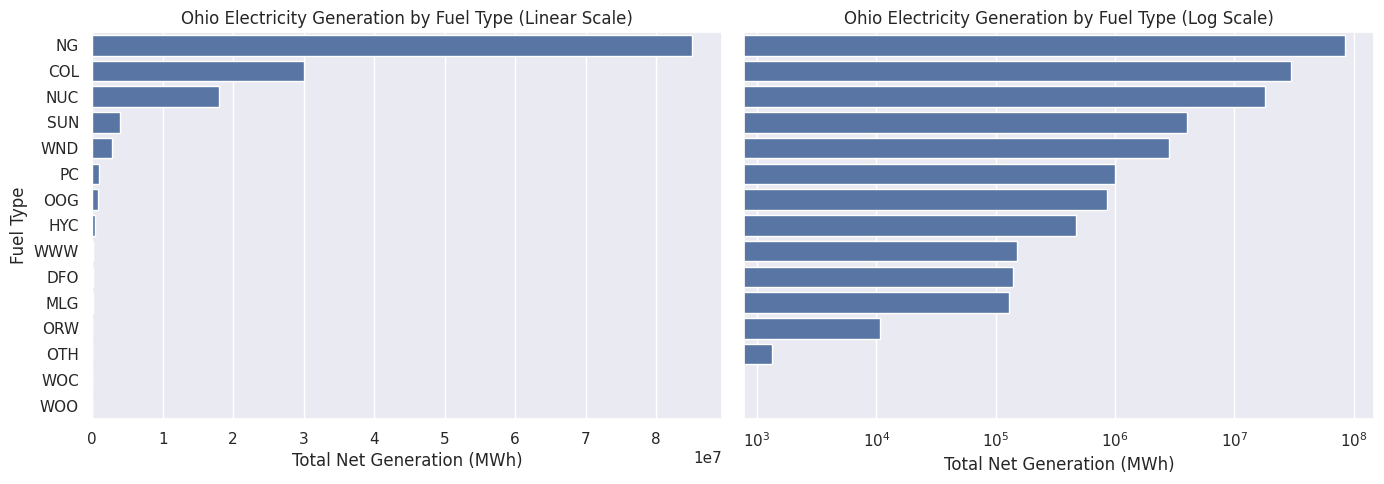

In [542]:
fuel_mix = (
    oh.groupby('fuel_code')['net_generation_mwh']
      .sum()
      .sort_values(ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Linear scale
sns.barplot(
    x=fuel_mix.values,
    y=fuel_mix.index,
    orient='h',
    ax=axes[0]
)
axes[0].set_xlabel("Total Net Generation (MWh)")
axes[0].set_ylabel("Fuel Type")
axes[0].set_title("Ohio Electricity Generation by Fuel Type (Linear Scale)")

# Log scale
sns.barplot(
    x=fuel_mix.values,
    y=fuel_mix.index,
    orient='h',
    ax=axes[1]
)
axes[1].set_xscale('log')
axes[1].set_xlabel("Total Net Generation (MWh)")
axes[1].set_title("Ohio Electricity Generation by Fuel Type (Log Scale)")

plt.tight_layout()
plt.show()



Ohio electricity generation spans multiple orders of magnitude across fuel types.

Natural gas is the dominant source of electricity, followed by coal and nuclear generation at lower but still substantial levels.

Smaller fuel categories contribute electricity at much lower scales, which becomes visible when using a logarithmic scale.

This distribution indicates a fuel mix that is heavily concentrated in a few dominant sources rather than evenly spread across fuel types.


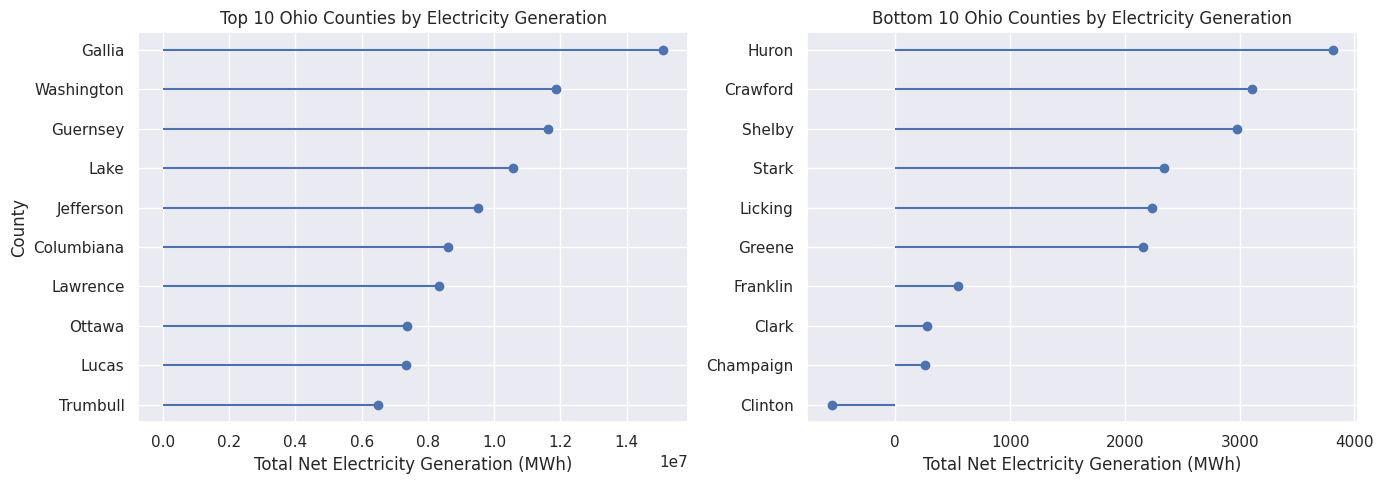

In [543]:
county_gen = (
    oh.dropna(subset=['county'])
      .groupby('county')['net_generation_mwh']
      .sum()
      .sort_values(ascending=False)
)

n = 10

top_counties = county_gen.sort_values(ascending=False).head(n)
bottom_counties = county_gen.sort_values(ascending=True).head(n)


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# -------- Top N counties --------
axes[0].hlines(
    y=top_counties.index,
    xmin=0,
    xmax=top_counties.values
)
axes[0].plot(
    top_counties.values,
    top_counties.index,
    'o'
)
axes[0].invert_yaxis()

axes[0].set_title(f"Top {n} Ohio Counties by Electricity Generation")
axes[0].set_xlabel("Total Net Electricity Generation (MWh)")
axes[0].set_ylabel("County")

# -------- Bottom N counties --------
axes[1].hlines(
    y=bottom_counties.index,
    xmin=0,
    xmax=bottom_counties.values
)
axes[1].plot(
    bottom_counties.values,
    bottom_counties.index,
    'o'
)

axes[1].set_title(f"Bottom {n} Ohio Counties by Electricity Generation")
axes[1].set_xlabel("Total Net Electricity Generation (MWh)")

plt.tight_layout()
plt.show()



Electricity generation in Ohio is highly uneven across counties.
The left panel shows that a small group of counties produces very large amounts of electricity, with the top counties contributing on the order of tens of millions of megawatt-hours.

In contrast, the right panel highlights counties whose electricity generation is several orders of magnitude smaller, in some cases only a few thousand megawatt-hours.

Clinton county exhibits negative total net electricity generation, as shown in the lower tail of the distribution. This arises from how net generation is reported, reflecting plant-level consumption and accounting adjustments rather than physical “negative production.”

Together, these panels demonstrate a strong disparity between the highest- and lowest-producing counties, indicating substantial geographic concentration of electricity generation rather than uniform distribution across the state.


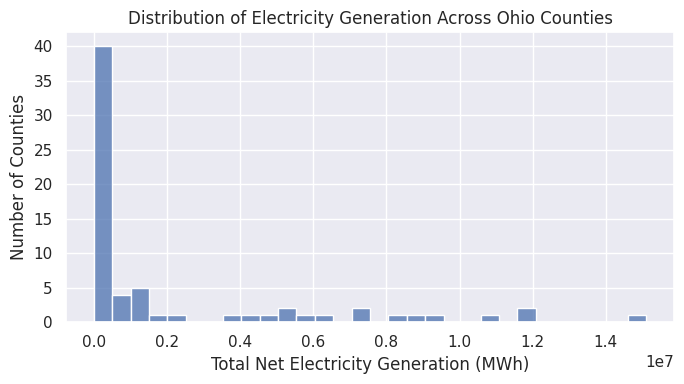

In [544]:
plt.figure(figsize=(7, 4))
sns.histplot(county_gen.values, bins=30)

plt.xlabel("Total Net Electricity Generation (MWh)")
plt.ylabel("Number of Counties")
plt.title("Distribution of Electricity Generation Across Ohio Counties")

plt.tight_layout()
plt.show()


The distribution of county-level electricity generation is strongly right-skewed.

Most counties generate relatively small amounts of electricity, while a small number of counties account for very large generation levels.

Together with the top–bottom comparison, this confirms a pronounced head–tail structure and highlights strong geographic concentration of electricity generation infrastructure across Ohio.

In [545]:
county_gen.describe()

,net_generation_mwh
count,6.700000e+01
mean,2.118240e+06
std,3.611296e+06
min,-5.520000e+02
25%,1.707650e+04
50%,1.821090e+05
75%,1.953597e+06
max,1.510928e+07


### Handling Missing County Information

A small number of Ohio records were missing county information.

In [546]:
oh.head(3)

,plant_id,plant_state,fuel_code,net_generation_mwh,plant_code,state,county,_merge
2141,2828,OH,COL,9461214.000,2828.0,OH,Jefferson,both
2142,2828,OH,DFO,35910.984,2828.0,OH,Jefferson,both
2143,2830,OH,OTH,-522.000,2830.0,OH,Clermont,both


In [547]:
oh[oh['county'].isna()]['plant_id'].unique()

array([ 8867, 99999])

In [548]:
display(df1[df1['Plant Id'] ==99999]['Plant Name'].unique())
display(df1[df1['Plant Id'] ==8867]['Plant Name'].unique())

array(['State-Fuel Level Increment'], dtype=object)

array(['Warrenton Terminal'], dtype=object)

In [549]:
# Removing non-physical state-level adjustment record
oh = oh[oh['plant_id'] != 99999]

In [550]:
oh = oh[oh['plant_id'] != 8867]

In [551]:
oh.isna().sum()

,0
plant_id,0
plant_state,0
fuel_code,0
net_generation_mwh,0
plant_code,0
state,0
county,0
_merge,0


Inspection of the plant names associated with missing county records confirms that some of these entries do not correspond to physical electricity generation facilities.

Plant Id 99999 represents a State-Fuel Level Increment, which is an accounting-level adjustment rather than a plant located in a specific county.
Plant Id 8867 corresponds to Warrenton Terminal, does not appear with county-level plant metadata.
Because it does not map to a physical plant location, it is treated as a non-plant reporting entry and excluded from county-based analysis.

Because these entries do not represent county-based electricity generation, they are excluded from the Ohio dataset.

After their removal, all remaining Ohio records have valid county information.

## Duplicate Record Checks

Before constructing features for clustering, we check whether any rows are exact duplicates across key fields.

Exact duplicates in this case would indicate redundant records rather than legitimate multiple observations.

In [552]:
dup_rows = oh[
    oh.duplicated(
        subset=['plant_id', 'fuel_code', 'net_generation_mwh', 'county'],
        keep=False
    )
]

dup_rows


,plant_id,plant_state,fuel_code,net_generation_mwh,plant_code,state,county,_merge
8964,57929,OH,COL,0.0,57929.0,OH,Hamilton,both
8966,57929,OH,NG,0.0,57929.0,OH,Hamilton,both
8968,57929,OH,COL,0.0,57929.0,OH,Hamilton,both
8970,57929,OH,NG,0.0,57929.0,OH,Hamilton,both


In [553]:
oh = oh.drop_duplicates(
    subset=['plant_id', 'fuel_code', 'net_generation_mwh', 'county']
)


The duplicate records are identical across plant ID, fuel type, net generation, and county.

These rows represent redundant entries rather than distinct observations.

The duplicate records are therefore removed to avoid redundancy in subsequent analysis.


## Feature Preparation for Unsupervised Analysis

To explore structural patterns across energy facilities, we construct a plant-level feature representation based on generation characteristics. This representation will be used for clustering and dimensionality reduction.


In [554]:
county_fuel = (
    oh
    .groupby(['county', 'fuel_code'], as_index=False)
    .agg(
        total_generation_mwh=('net_generation_mwh', 'sum'),
        n_records=('net_generation_mwh', 'count')
    )
)

county_fuel.head(5)


,county,fuel_code,total_generation_mwh,n_records
0,Ashtabula,MLG,16144.000,1
1,Ashtabula,NG,165965.000,2
2,Auglaize,COL,0.000,1
3,Auglaize,DFO,218.391,1
4,Auglaize,NG,131.609,1


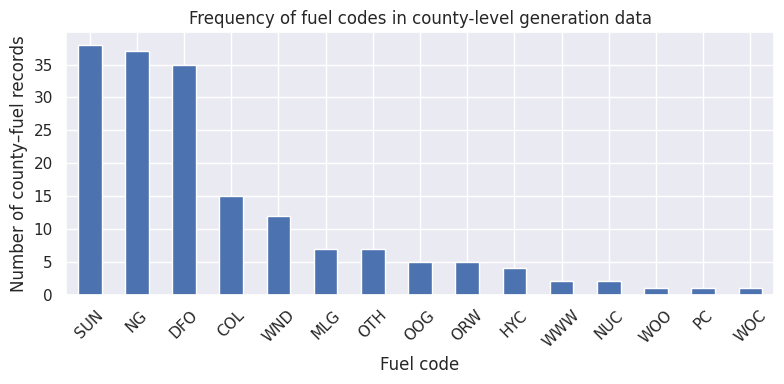

In [555]:
plt.figure(figsize=(8,4))
county_fuel['fuel_code'].value_counts().plot(kind='bar')
plt.title('Frequency of fuel codes in county-level generation data')
plt.xlabel('Fuel code')
plt.ylabel('Number of county–fuel records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The distribution of fuel codes across county-level generation records highlights clear differences in how energy sources are represented spatially across Ohio.

Solar (SUN), natural gas (NG), and distillate fuel oil (DFO) appear most frequently, indicating that these fuel types are present across a large number of counties. This reflects widespread geographic coverage rather than total energy contribution.

Coal (COL) and wind (WND) appear in a moderate number of counties, suggesting more spatial concentration. These fuel types may therefore play an important role in distinguishing counties with specific energy profiles in downstream clustering analyses.

Several fuel codes occur only rarely, forming a long tail in the distribution. Treating each of these fuels as a separate feature would introduce sparsity and potentially destabilize unsupervised learning methods. To address this, individual fuel codes are grouped into broader fuel categories, reducing dimensionality while preserving meaningful distinctions in energy composition.


In [556]:
# Defining fuel group mapping
fuel_map = {
    # Core fuels
    'COL': 'Coal',
    'NG': 'Natural Gas',
    'NUC': 'Nuclear',

    # Renewables
    'SUN': 'Renewables',
    'WND': 'Renewables',
    'HYC': 'Renewables',
    'MLG': 'Renewables',
    'WWW': 'Renewables',
    'WOO': 'Renewables',
    'WOC': 'Renewables',
    'ORW': 'Renewables',
    'OOG': 'Renewables',

    # Other fuels
    'DFO': 'Other fuels',
    'PC':  'Other fuels',
    'OTH': 'Other fuels'
}

county_fuel['fuel_group'] = county_fuel['fuel_code'].map(fuel_map)

# Keep only rows that mapped to a fuel group
county_fuel_grouped = county_fuel.dropna(subset=['fuel_group']).copy()

county_fuel_grouped.head()


,county,fuel_code,total_generation_mwh,n_records,fuel_group
0,Ashtabula,MLG,16144.000,1,Renewables
1,Ashtabula,NG,165965.000,2,Natural Gas
2,Auglaize,COL,0.000,1,Coal
3,Auglaize,DFO,218.391,1,Other fuels
4,Auglaize,NG,131.609,1,Natural Gas


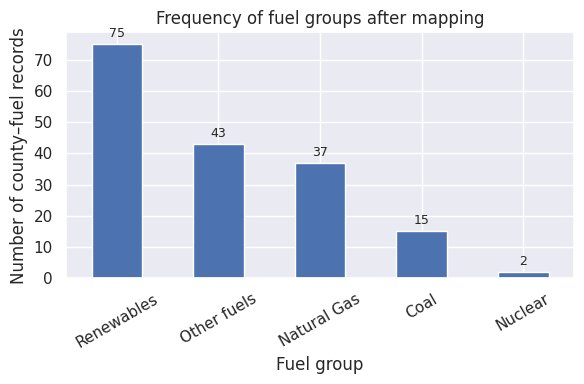

In [557]:
plt.figure(figsize=(6,4))
ax = county_fuel_grouped['fuel_group'].value_counts().plot(kind='bar')

plt.title('Frequency of fuel groups after mapping')
plt.xlabel('Fuel group')
plt.ylabel('Number of county–fuel records')
plt.xticks(rotation=30)

# Add value annotations on bars
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=9,
        xytext=(0, 3),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()


These grouped fuel categories form the basis for constructing county-level feature vectors used in unsupervised analyses.


In [558]:
# Dropping raw fuel code column
df = county_fuel_grouped.drop(columns=['fuel_code']).copy()
df.head(5)


,county,total_generation_mwh,n_records,fuel_group
0,Ashtabula,16144.000,1,Renewables
1,Ashtabula,165965.000,2,Natural Gas
2,Auglaize,0.000,1,Coal
3,Auglaize,218.391,1,Other fuels
4,Auglaize,131.609,1,Natural Gas


### Constructing County-Level Fuel Share Features

To compare counties based on their energy composition rather than absolute generation size, total generation is normalized at the county level. For each county, the share of electricity generation attributable to each fuel group is computed.

These fuel shares provide scale-invariant features that capture the relative energy mix of each county and are well suited for unsupervised learning methods.


In [559]:
display(df[df['county'] == 'Clermont'])
display(df[df['county'] == 'Wood'])

,county,total_generation_mwh,n_records,fuel_group
18,Clermont,0.0,1,Coal
19,Clermont,0.0,1,Other fuels
20,Clermont,-522.0,1,Other fuels
21,Clermont,140212.0,1,Renewables


,county,total_generation_mwh,n_records,fuel_group
165,Wood,2457.854,2,Other fuels
166,Wood,991601.151,3,Natural Gas
167,Wood,-2591.000,1,Other fuels
168,Wood,42356.000,3,Renewables
169,Wood,3588.000,1,Renewables


Because fuel shares are intended to represent compositional contributions of energy sources, negative net generation values are not meaningful in this context.

To ensure interpretability and stability of fuel-share features, negative generation values are clipped to zero prior to normalization.

In [560]:
# Remove negative net generation for composition analysis
df['generation_nonneg'] = df['total_generation_mwh'].clip(lower=0)

df['county_total_mwh'] = (
    df.groupby('county')['generation_nonneg']
      .transform('sum')
)

df['fuel_share'] = df['generation_nonneg'] / df['county_total_mwh']

In [561]:
df.head()

,county,total_generation_mwh,n_records,fuel_group,generation_nonneg,county_total_mwh,fuel_share
0,Ashtabula,16144.000,1,Renewables,16144.000,182109.0,0.088650
1,Ashtabula,165965.000,2,Natural Gas,165965.000,182109.0,0.911350
2,Auglaize,0.000,1,Coal,0.000,33924.0,0.000000
3,Auglaize,218.391,1,Other fuels,218.391,33924.0,0.006438
4,Auglaize,131.609,1,Natural Gas,131.609,33924.0,0.003880


In [562]:
# Sanity check: fuel shares should sum to 1 per county
fuel_share_check = (
    df.groupby('county')['fuel_share']
      .sum()
)

fuel_share_check.describe()


,fuel_share
count,67.000000
mean,0.985075
std,0.122169
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


The fuel share values sum to approximately one for each county, confirming that the normalization step was applied correctly.

### Creating the County–Fuel Feature Matrix

To prepare the data for unsupervised learning, the normalized fuel shares are reshaped into a county-level feature matrix. Each row represents a county, and each column corresponds to the share of electricity generation from a given fuel group.

Counties with no generation from a particular fuel group are assigned a value of zero.

This matrix forms the core input for subsequent scaling, dimensionality reduction, and clustering analyses.


In [563]:
# Pivot to county × fuel group matrix
X = (
    df.pivot_table(
        index='county',
        columns='fuel_group',
        values='fuel_share',
        aggfunc='sum'   # collapse duplicates
    )
    .fillna(0)
)

X.head()

fuel_group,Coal,Natural Gas,Nuclear,Other fuels,Renewables
county,,,,,
Ashtabula,0.0,0.911350,0.0,0.000000,0.088650
Auglaize,0.0,0.003880,0.0,0.006438,0.989683
Brown,0.0,0.000000,0.0,0.000000,1.000000
Butler,0.0,0.935122,0.0,0.001020,0.063858
Carroll,0.0,1.000000,0.0,0.000000,0.000000


In [564]:
X.shape, X.columns

((67, 5),
 Index(['Coal', 'Natural Gas', 'Nuclear', 'Other fuels', 'Renewables'], dtype='object', name='fuel_group'))

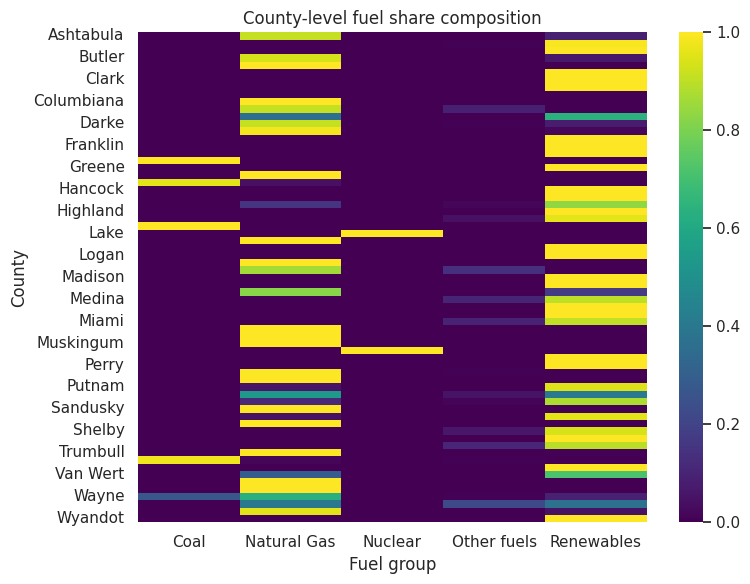

In [565]:
plt.figure(figsize=(8,6))
sns.heatmap(X, cmap='viridis')
plt.title('County-level fuel share composition')
plt.xlabel('Fuel group')
plt.ylabel('County')
plt.tight_layout()
plt.show()


The heatmap reveals strong heterogeneity in county-level energy composition. Many counties exhibit near-complete reliance on a single fuel group, reflecting the localized nature of energy infrastructure and generation assets.

Natural gas and renewables dominate the energy mix across most counties, while coal and nuclear generation are highly concentrated in a small number of locations.

The resulting feature matrix is sparse by design, with zero values indicating the absence of specific fuel types.

These patterns suggest that counties are likely to cluster according to dominant fuel sources. To ensure that no single fuel group disproportionately influences distance-based methods, feature scaling is applied in the next step prior to dimensionality reduction and clustering.

For readability, only a subset of county labels is shown on the heatmap.


In [566]:
X.describe(include='all')

fuel_group,Coal,Natural Gas,Nuclear,Other fuels,Renewables
count,67.000000,67.000000,67.000000,67.000000,67.000000
mean,0.062702,0.371903,0.029849,0.014512,0.506108
std,0.235787,0.451754,0.171449,0.038802,0.470504
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.012740,0.000000,0.000000,0.639938
75%,0.000000,0.944291,0.000000,0.003781,1.000000
max,0.996219,1.000000,0.999969,0.222626,1.000000


Summary statistics of the county-level fuel share features further highlight the heterogeneity in Ohio’s energy composition.

Most fuel groups exhibit a median share of zero, indicating that many counties do not generate electricity from these sources at all.

In contrast, renewables show a high median value, reflecting their widespread presence across counties.

Natural gas and renewables display large variability, as indicated by their high standard deviations, suggesting substantial differences in reliance on these fuel sources across counties.

Coal and nuclear generation are highly concentrated, with near-unity maximum values but low mean shares.


In [567]:
(X == 0).mean().sort_values()

,0
fuel_group,
Renewables,0.268657
Natural Gas,0.447761
Other fuels,0.507463
Coal,0.910448
Nuclear,0.970149


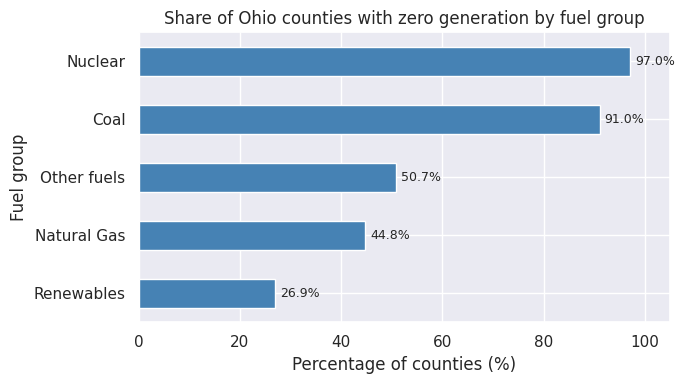

In [568]:
zero_share = (X == 0).mean().sort_values()

plt.figure(figsize=(7,4))
ax = zero_share.mul(100).plot(
    kind='barh',
    color='steelblue'
)

plt.title('Share of Ohio counties with zero generation by fuel group')
plt.xlabel('Percentage of counties (%)')
plt.ylabel('Fuel group')

# Add annotations
for i, v in enumerate(zero_share.mul(100)):
    ax.text(
        v + 1,
        i,
        f'{v:.1f}%',
        va='center',
        fontsize=9
    )

plt.xlim(0, 105)
plt.tight_layout()
plt.show()


- Nuclear energy is not present in approximately 97% of Ohio counties, indicating extreme spatial concentration of nuclear generation.
- Coal generation is absent in about 91% of counties, reflecting the limited number of coal-based generation sites.
- Natural gas generation is not present in roughly 45% of counties.
- Renewable generation is the most widespread, with fewer than 27% of counties exhibiting zero renewable generation.


In [569]:
X.var().sort_values()

,0
fuel_group,
Other fuels,0.001506
Nuclear,0.029395
Coal,0.055595
Natural Gas,0.204082
Renewables,0.221374


### Feature Scaling

The county-level fuel share features exhibit substantial differences in sparsity and variance across fuel groups. Some fuel groups (e.g., renewables) are widespread with high variability, while others (e.g., coal and nuclear) are highly concentrated and mostly zero.

Because distance-based methods such as PCA, K-means, and t-SNE are sensitive to feature scale and variance, the feature matrix is standardized prior to dimensionality reduction and clustering. Standardization ensures that each fuel group contributes comparably to distance computations.


In [570]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled.head(2)

fuel_group,Coal,Natural Gas,Nuclear,Other fuels,Renewables
county,,,,,
Ashtabula,-0.267935,1.203127,-0.175412,-0.376831,-0.893953
Auglaize,-0.267935,-0.820804,-0.175412,-0.209669,1.035539


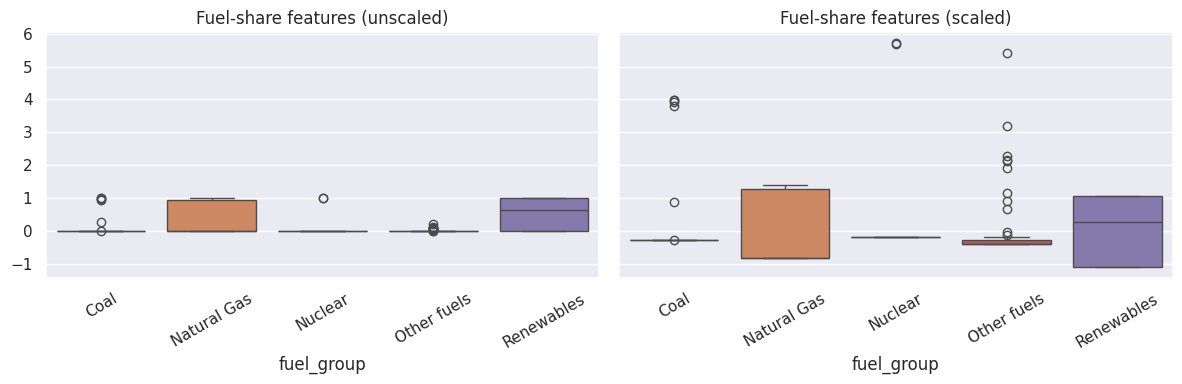

In [571]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

# Before scaling
sns.boxplot(data=X, ax=axes[0])
axes[0].set_title('Fuel-share features (unscaled)')
axes[0].tick_params(axis='x', rotation=30)

# After scaling
sns.boxplot(data=pd.DataFrame(X_scaled, columns=X.columns), ax=axes[1])
axes[1].set_title('Fuel-share features (scaled)')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


The comparison between unscaled and scaled fuel-share features illustrates the impact of standardization. Prior to scaling, fuel groups differ substantially in spread and concentration, with renewables and natural gas exhibiting much larger variability than coal or nuclear.

After standardization, all features are centered and scaled to comparable variance. This prevents any single fuel group from disproportionately influencing distance-based methods, while preserving the relative structure of the data.

### Principal Component Analysis (PCA)

Principal Component Analysis is applied to the scaled fuel-share feature matrix to reduce dimensionality while preserving the dominant patterns of variation across counties. PCA identifies orthogonal directions (principal components) that capture the largest sources of variance in the data.

This step serves two purposes:
1. To assess the intrinsic dimensionality of county-level energy composition.
2. To provide a lower-dimensional representation for visualization and clustering.


In [572]:
pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X_scaled))

explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.35848021, 0.23426807, 0.20956847, 0.19186611, 0.00581714])

In [573]:
# Explained variance
explained_var = pd.Series(
    pca.explained_variance_ratio_,
    index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]
)

explained_var.cumsum()


,0
PC1,0.358480
PC2,0.592748
PC3,0.802317
PC4,0.994183
PC5,1.000000


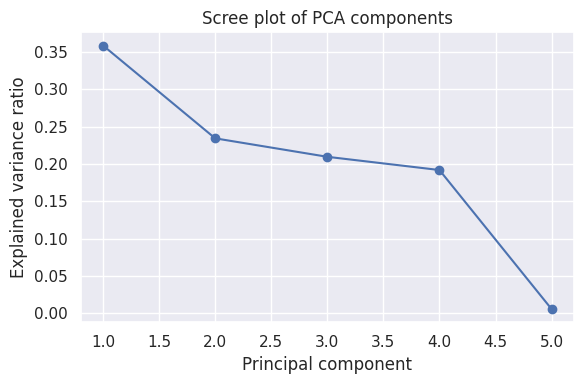

In [574]:
plt.figure(figsize=(6,4))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker='o'
)
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Scree plot of PCA components')
plt.tight_layout()
plt.show()


The scree plot shows that the first principal component accounts for approximately 35% of the total variance in county-level fuel composition, indicating a strong dominant axis of variation. Subsequent components explain progressively smaller, but still meaningful, proportions of variance, with no sharp elbow point.

This gradual decay suggests that multiple dimensions contribute to differences in county energy profiles.


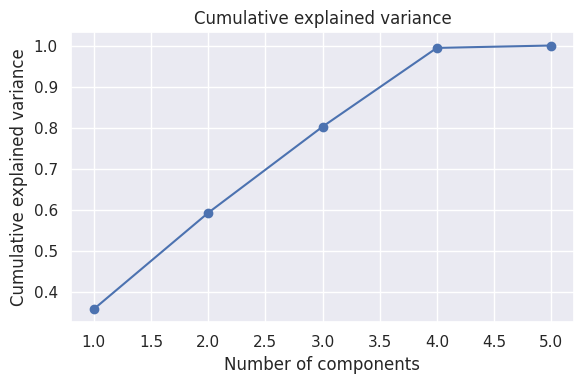

In [575]:
plt.figure(figsize=(6,4))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance.cumsum(),
    marker='o'
)

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance')
plt.tight_layout()
plt.show()


Because fuel shares sum to one, the county-level energy mix lies in a four-dimensional subspace. Accordingly, PCA captures 100% of the variance using four components.

In [576]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f'PC{i+1}' for i in range(X.shape[1])]
)

loadings


,PC1,PC2,PC3,PC4,PC5
fuel_group,,,,,
Coal,-0.097300,0.700721,-0.597861,0.177233,0.332677
Natural Gas,-0.683103,-0.327943,0.030257,-0.161693,0.631477
Nuclear,-0.044508,0.439242,0.771907,0.387976,0.242321
Other fuels,0.030323,-0.423390,-0.213973,0.878477,0.048115
Renewables,0.721805,-0.171031,0.004629,-0.142113,0.655384


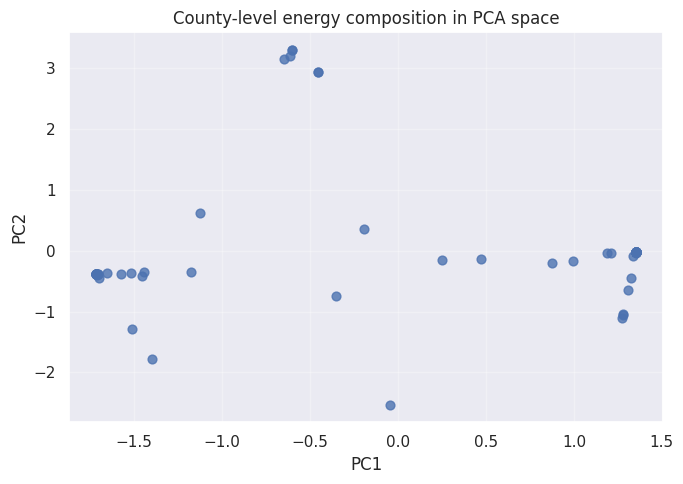

In [577]:
pca_df = X_pca.iloc[:, :2].copy()
pca_df.columns = ['PC1', 'PC2']
pca_df.index = X.index

plt.figure(figsize=(7,5))
plt.scatter(pca_df['PC1'], pca_df['PC2'], s=40, marker='o', alpha=0.8)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('County-level energy composition in PCA space')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


This visualization is intended as a diagnostic view of the dominant axes of variation.


### t-SNE Visualization of County-Level Energy Composition

While PCA captures global variance structure, it is a linear method and may not fully reveal local similarities between counties. To better visualize neighborhood-level structure in the data, t-distributed Stochastic Neighbor Embedding (t-SNE) is applied to the scaled fuel-share features.

t-SNE is used here as a visualization tool to explore local grouping patterns among counties.


In [578]:
X_pca_4 = X_pca.iloc[:, :4].copy()
X_pca_4.columns = ['PC1', 'PC2', 'PC3', 'PC4']
X_pca_4.head(2)

,PC1,PC2,PC3,PC4
0,-1.444669,-0.346914,0.137683,-0.514075
1,1.335670,-0.083956,0.049609,-0.314177


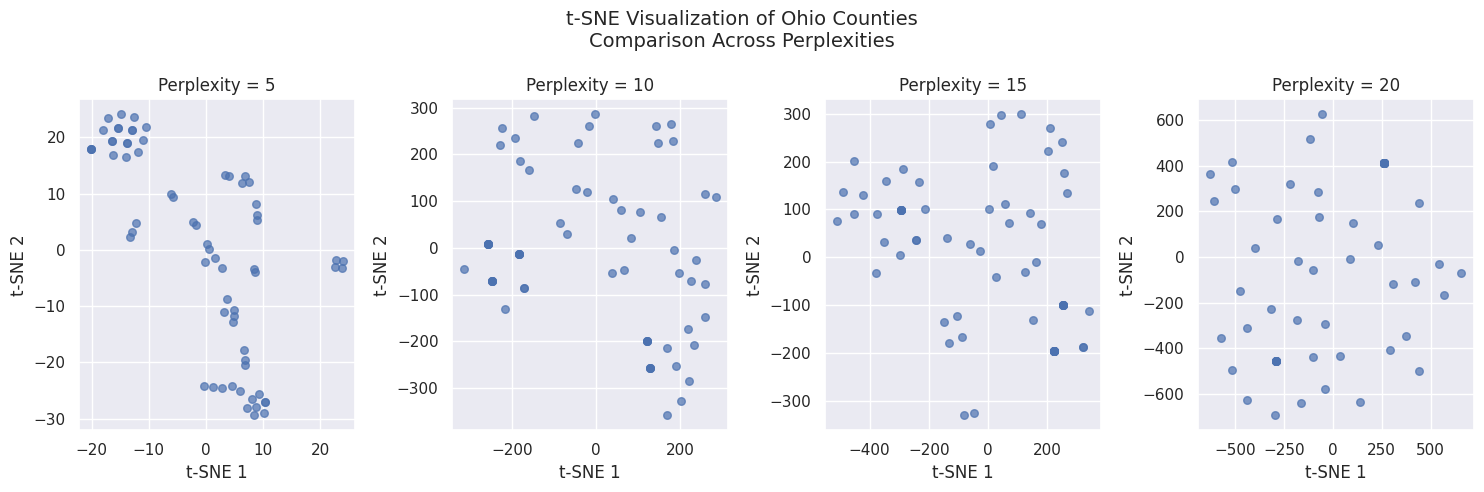

In [579]:
# Trying a few perplexity values
perplexities = [5, 10, 15, 20]

tsne_results = {}

for p in perplexities:
    tsne = TSNE(
        n_components = 2, perplexity = p, random_state =1, init = 'pca', learning_rate = 'auto' )
    tsne_results[p] = tsne.fit_transform(X_pca_4)


tsne_dfs = {}

for p, coords in tsne_results.items():
    tsne_dfs[p] = pd.DataFrame(coords, index = X_pca_4.index, columns = ['tSNE1', 'tSNE2'] )


# visualization
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=False, sharey=False)

for ax, p in zip(axes, perplexities):
    ax.scatter(
        tsne_dfs[p]['tSNE1'],
        tsne_dfs[p]['tSNE2'],
        s=30,
        alpha=0.7
    )
    ax.set_title(f"Perplexity = {p}")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

fig.suptitle("t-SNE Visualization of Ohio Counties\nComparison Across Perplexities", fontsize=14)
plt.tight_layout()
plt.show()


To assess the robustness of the t-SNE visualization, multiple perplexity values were explored. Lower perplexities emphasize very local structure and result in tightly packed clusters, while higher perplexities produce more diffuse layouts that emphasize broader relationships.

A perplexity of 15 provides a balanced representation, preserving local similarity while maintaining a coherent global layout. This value is used for subsequent visual analysis.

## **K-Means Clustering**

In [580]:
inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20)
    labels = kmeans.fit_predict(X_pca_4)

    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca_4, labels))

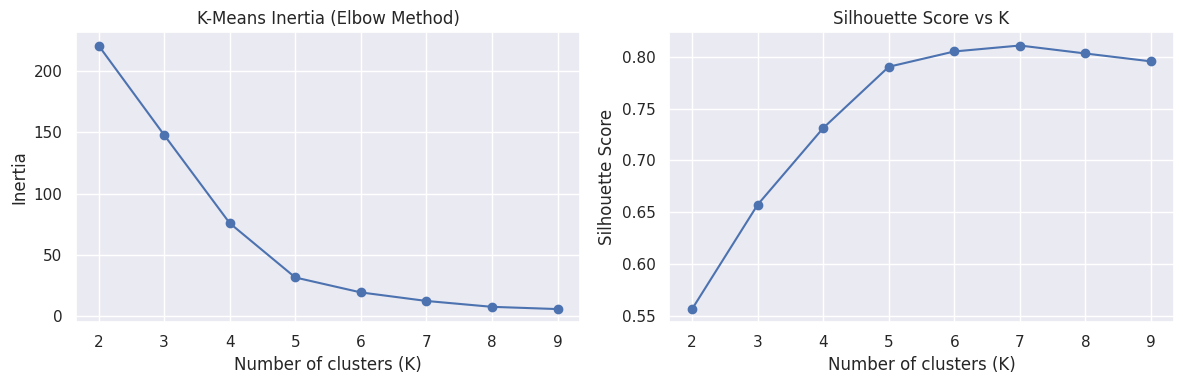

In [581]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Inertia (Elbow Method)
axes[0].plot(K, inertia, marker='o')
axes[0].set_title("K-Means Inertia (Elbow Method)")
axes[0].set_xlabel("Number of clusters (K)")
axes[0].set_ylabel("Inertia")
axes[0].grid(True)

# Silhouette Score
axes[1].plot(K, silhouette, marker='o')
axes[1].set_title("Silhouette Score vs K")
axes[1].set_xlabel("Number of clusters (K)")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Selecting the number of clusters

The elbow method is used as the primary criterion for selecting the number of clusters, as it highlights diminishing returns in within-cluster variance reduction as \(K\) increases. In this case, a clear elbow is observed around \(K = 5\), beyond which reductions in inertia become marginal.

The silhouette score is included as a secondary diagnostic to verify that the chosen value of \(K\) yields well-separated clusters. While the silhouette score continues to increase slightly for larger values of \(K\), this behavior reflects improved separation with additional clusters rather than a fundamentally better clustering structure.

Based on the elbow method and supported by the silhouette scores, \(K = 5\) is selected for the final K-means model.

Using $K = 5$, we fit the K-means model on the PCA-reduced feature space and assign each county to a cluster.

In [582]:
# Fit final K-Means model (K = 5)
kmeans_final = KMeans(n_clusters=5, random_state=1, n_init=20)
kmeans_labels = kmeans_final.fit_predict(X_pca_4)

# Attach labels
km_df = X.copy()
km_df["KMeans_Cluster"] = kmeans_labels

# Quick check: cluster counts
km_df["KMeans_Cluster"].value_counts().sort_index()


,count
KMeans_Cluster,
0,32
1,24
2,4
3,5
4,2


In [583]:
def clean_name(s):
    return str(s).strip().lower()

base_map = ohio_map.copy()
base_map["county_clean"] = base_map["NAME"].apply(clean_name)

cluster_colors = {
    0: "#1f77b4",  # blue
    1: "#ff7f0e",  # orange
    2: "#2ca02c",  # green
    3: "#d62728",  # red
    4: "#9467bd"   # purple
}

def plot_cluster_map(cluster_df, cluster_col, title):
    # Build county->cluster table
    tmp = cluster_df[[cluster_col]].copy()
    tmp.index.name = "county"
    tmp = tmp.reset_index()
    tmp["county_clean"] = tmp["county"].apply(clean_name)

    # Merge onto geometry
    gdf = base_map.merge(
        tmp[["county_clean", cluster_col]],
        on="county_clean",
        how="left"
    )

    # Keep NaNs for missing counties
    gdf[cluster_col] = gdf[cluster_col].astype("Float64")

    # Discrete colormap in order 0..4
    cmap = ListedColormap([cluster_colors[i] for i in range(5)])

    fig, ax = plt.subplots(1, 1, figsize=(9, 10))

    gdf.plot(
        column=cluster_col,
        cmap=cmap,
        vmin=0, vmax=4,
        legend=False,
        edgecolor="white",
        linewidth=0.6,
        ax=ax,
        missing_kwds={"color": "lightgrey"}
    )

    # Legend
    handles = [mpatches.Patch(color=cluster_colors[i], label=str(i)) for i in range(5)]
    handles.append(mpatches.Patch(color="lightgrey", label="No generation data"))

    ax.legend(handles=handles, title=cluster_col, loc="upper right", frameon=True)

    ax.set_title(title, pad=12)
    ax.axis("off")
    plt.show()


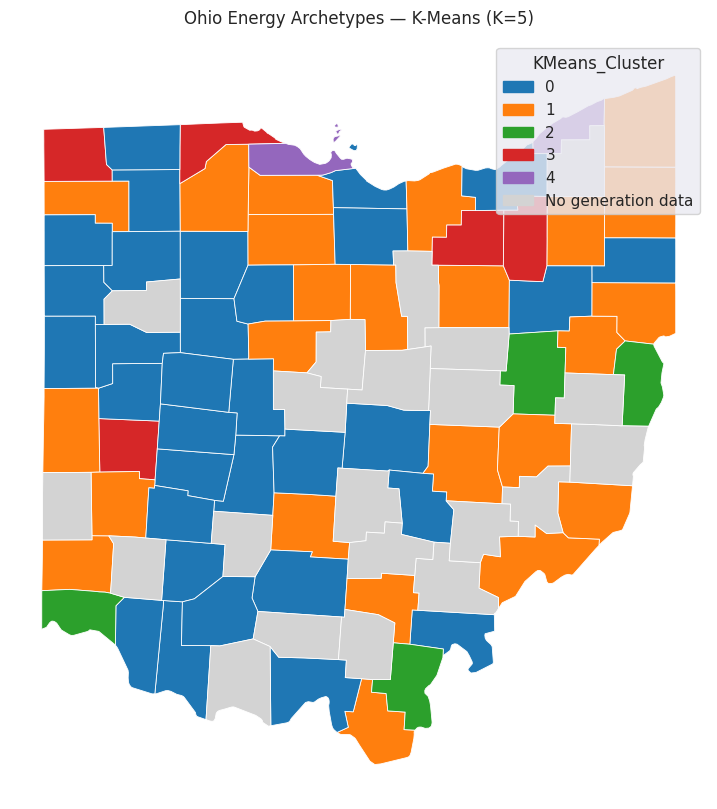

In [584]:
plot_cluster_map(
    km_df,
    "KMeans_Cluster",
    "Ohio Energy Archetypes — K-Means (K=5)"
)

Counties are grouped primarily according to dominant fuel composition, resulting in large regional patterns corresponding to renewables-dominant, natural-gas–dominant, coal-dominant, nuclear-dominant, and mixed-profile energy systems.

This representation emphasizes large-scale structural similarities in county-level energy composition and serves as a spatial visualization for the analysis.

In [585]:
km_cluster_profile = km_df.groupby('KMeans_Cluster').mean()

km_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

fuel_group,Coal,Natural Gas,Nuclear,Other fuels,Renewables
KMeans_Cluster,,,,,
0,0.000000,0.031715,0.000000,0.004169,0.932865
1,0.011381,0.941095,0.000000,0.006860,0.040664
2,0.981963,0.013442,0.000000,0.004523,0.000072
3,0.000000,0.252512,0.000000,0.131228,0.616260
4,0.000029,0.000016,0.999937,0.000018,0.000000


In [586]:
fuel_colors = {
    "Coal":        "#8c6d31",
    "Natural Gas": "#9ecae1",
    "Nuclear":     "#6baed6",
    "Other fuels": "#2f2f2f",
    "Renewables":  "#bdbdbd"
}


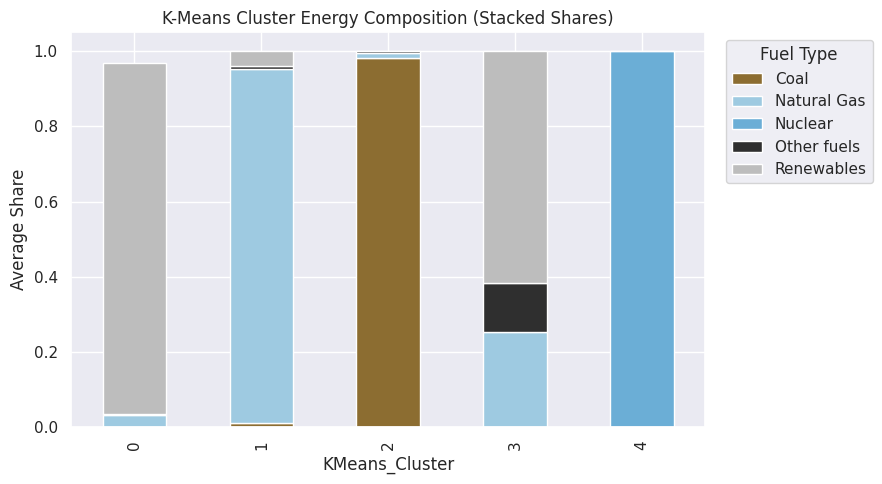

In [587]:
plot_df = km_cluster_profile.copy()

ax = plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(9, 5),
    color=[fuel_colors[c] for c in plot_df.columns]
)

ax.set_title("K-Means Cluster Energy Composition (Stacked Shares)")
ax.set_xlabel("KMeans_Cluster")
ax.set_ylabel("Average Share")
ax.legend(title="Fuel Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


The table above shows the mean energy composition for each cluster, allowing clusters to be interpreted as distinct energy-generation archetypes:

- **Cluster 0** is dominated by renewables, with negligible contributions from other fuel types.
- **Cluster 1** is strongly natural-gas–dominated, with minimal presence of other sources.
- **Cluster 2** represents coal-dominant counties, with coal accounting for nearly all generation.
- **Cluster 3** shows a mixed profile, combining renewables with a moderate share of natural gas and other fuels.
- **Cluster 4** corresponds to nuclear-dominant counties, with nuclear accounting for nearly all generation.

These profiles indicate that K-means successfully separates counties according to their dominant energy-generation patterns.


In [588]:
tsne_dfs[15].head()

,tSNE1,tSNE2
0,-489.627045,136.665329
1,28.520191,-42.466743
2,221.438126,-196.859604
3,-454.546173,90.260284
4,-293.622650,97.759186


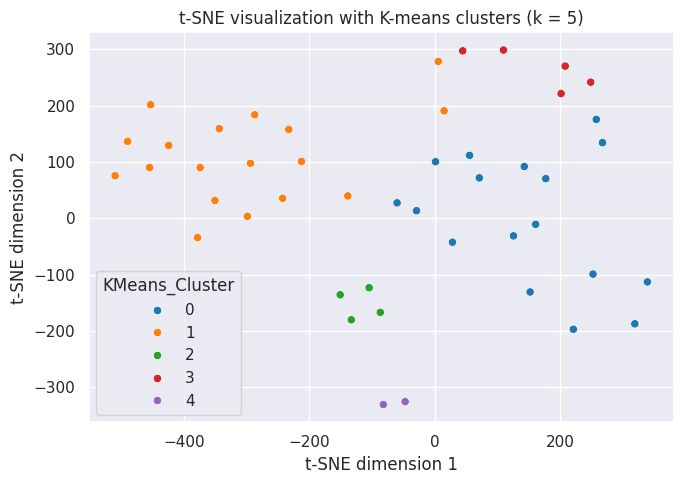

In [589]:
tsne_df = tsne_dfs[15].copy()

# Attach actual KMeans cluster labels
tsne_df["KMeans_Cluster"] = km_df["KMeans_Cluster"].values

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=tsne_df,
    x="tSNE1",
    y="tSNE2",
    hue="KMeans_Cluster",
    palette="tab10"
)

plt.title("t-SNE visualization with K-means clusters (k = 5)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(title="KMeans_Cluster")
plt.tight_layout()
plt.show()


## **K-Medoids Clustering (K = 5)**


In [590]:
# K-Medoids on scaled original features (consistent with K-Means)
kmedoids = KMedoids(n_clusters=5, metric="euclidean", random_state=1)
kmed_labels = kmedoids.fit_predict(X_pca_4)

kmed_df = X.copy()
kmed_df["KMedoids_Cluster"] = kmed_labels

kmed_df["KMedoids_Cluster"].value_counts().sort_index()

,count
KMedoids_Cluster,
0,6
1,4
2,7
3,22
4,28


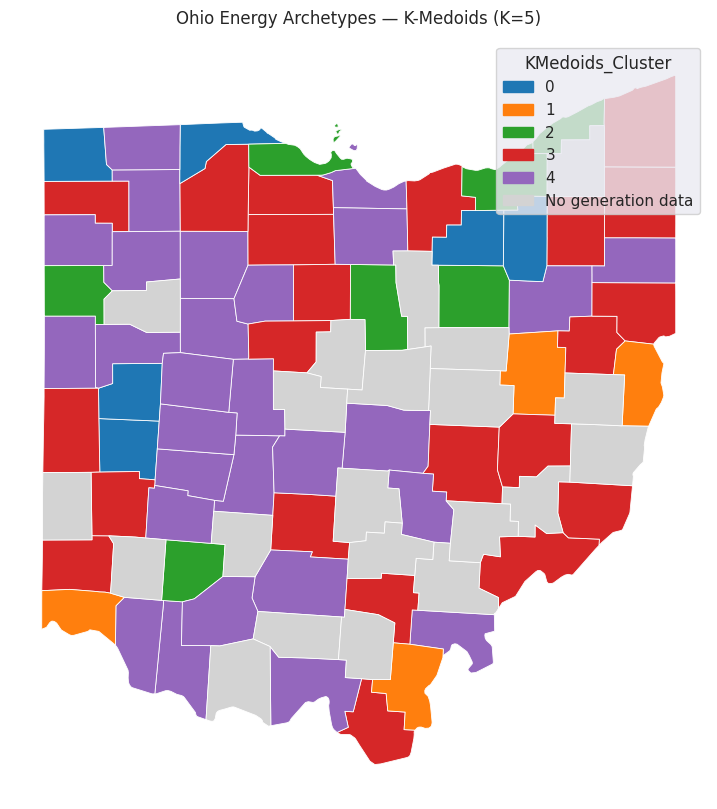

In [591]:
plot_cluster_map(
    kmed_df,
    "KMedoids_Cluster",
    "Ohio Energy Archetypes — K-Medoids (K=5)"
)

Despite increased local variability, the same dominant energy archetypes identified by K-Means are clearly present, indicating robustness of the underlying structure.

In [592]:
kmed_cluster_profile = kmed_df.groupby('KMedoids_Cluster').mean()
kmed_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

fuel_group,Coal,Natural Gas,Nuclear,Other fuels,Renewables
KMedoids_Cluster,,,,,
0,0.000000,0.210427,0.000000,0.119167,0.670406
1,0.981963,0.013442,0.000000,0.004523,0.000072
2,0.039029,0.259825,0.285696,0.008306,0.264288
3,0.000000,0.973309,0.000000,0.004968,0.021723
4,0.000000,0.013201,0.000000,0.002564,0.984235


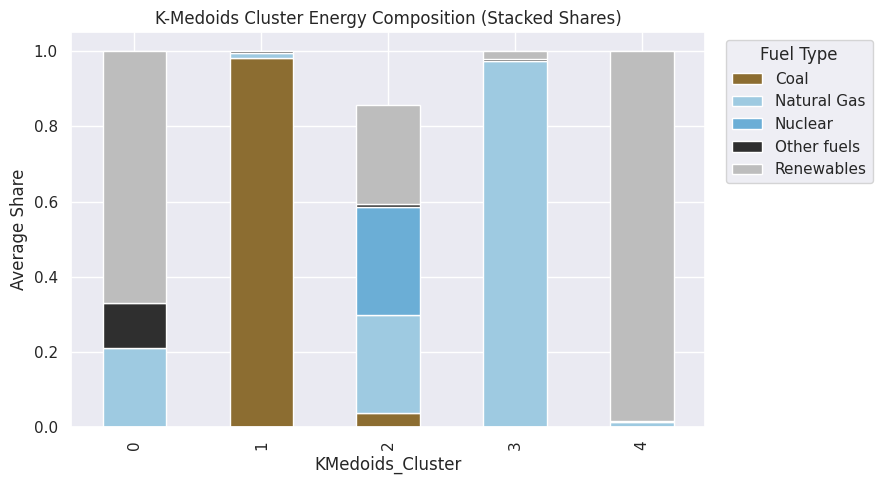

In [593]:
plot_df = kmed_cluster_profile.copy()

ax = plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(9, 5),
    color=[fuel_colors[c] for c in plot_df.columns]
)

ax.set_title("K-Medoids Cluster Energy Composition (Stacked Shares)")
ax.set_xlabel("KMedoids_Cluster")
ax.set_ylabel("Average Share")
ax.legend(title="Fuel Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


The K-Medoids cluster profiles indicate strong stability in the underlying energy-generation patterns.

Coal-dominant, natural-gas–dominant, renewables-dominant, and mixed-profile clusters are clearly identified.

The presence of a mixed cluster containing non-negligible shares of nuclear, renewables, and natural gas reflects counties with more diversified energy portfolios.

Overall, the similarities between K-Means and K-Medoids results suggests that the observed clustering structure is robust to the choice of clustering algorithm.


## **Hierarchical clustering (Ward linkage, K = 5)**

In [594]:
# Hierarchical clustering on scaled original features
Z = linkage(X_pca_4, method="ward")

# Cut dendrogram at K = 5
hc_labels = fcluster(Z, t=5, criterion="maxclust") - 1

# Attach labels
hc_df = X.copy()
hc_df["HC_Cluster"] = hc_labels

hc_df["HC_Cluster"].value_counts().sort_index()


,count
HC_Cluster,
0,29
1,8
2,24
3,2
4,4


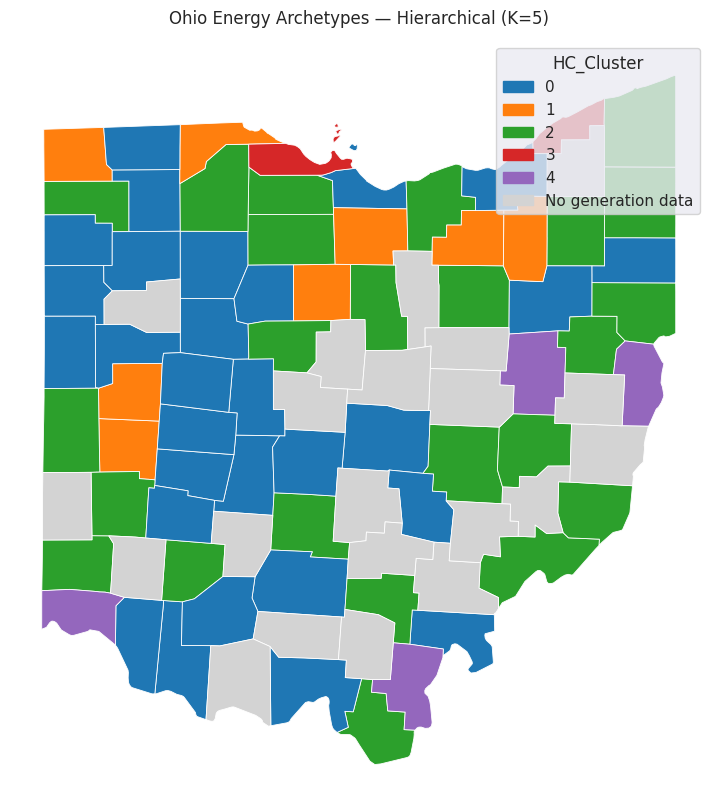

In [595]:
plot_cluster_map(
    hc_df,
    "HC_Cluster",
    "Ohio Energy Archetypes — Hierarchical (K=5)"
)

The map shows a close agreement between hierarchical clustering and the other methods.

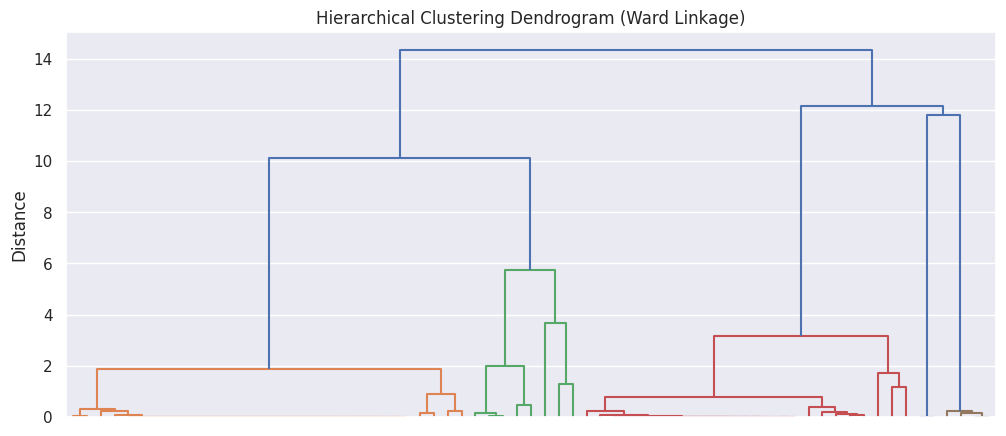

In [596]:
plt.figure(figsize=(12, 5))
dendrogram(Z, no_labels=True)
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
plt.ylabel("Distance")
plt.show()


The dendrogram produced using Ward linkage shows clear separation between groups, with large increases in linkage distance prior to the final merges.

Cutting the dendrogram to obtain five clusters is consistent with the structure suggested by the hierarchy and aligns with the number of clusters used in K-means and K-Medoids.

This agreement across methods supports the presence of stable and well-defined energy-generation archetypes among Ohio counties.


In [597]:
# Pairwise distances in PCA space
pairwise_dist = pdist(X_pca_4, metric="euclidean")

# Cophenetic correlation
coph_corr, coph_dist = cophenet(Z, pairwise_dist)

coph_corr

0.7792025486944671

The cophenetic correlation coefficient quantifies how well the hierarchical clustering preserves pairwise distances from the underlying feature space.

The obtained value (approximately 0.78) indicates that the dendrogram provides a reasonably faithful representation of the data’s distance structure, offering additional support for the hierarchical clustering results.


In [598]:
hc_cluster_profile = hc_df.groupby('HC_Cluster').mean()
hc_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

fuel_group,Coal,Natural Gas,Nuclear,Other fuels,Renewables
HC_Cluster,,,,,
0,0.000000,0.034996,0.000000,0.001186,0.963818
1,0.000000,0.271833,0.000000,0.105383,0.622783
2,0.011381,0.903091,0.000000,0.003197,0.040664
3,0.000029,0.000016,0.999937,0.000018,0.000000
4,0.981963,0.013442,0.000000,0.004523,0.000072


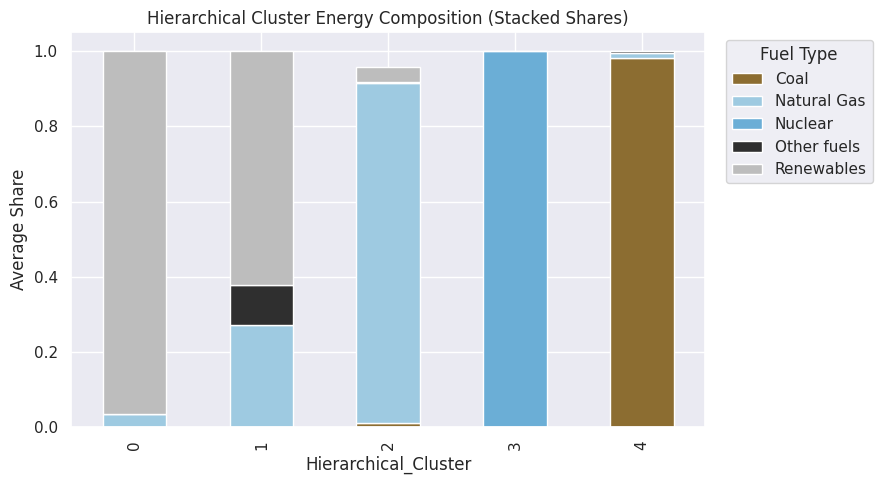

In [599]:
plot_df = hc_cluster_profile.copy()

ax = plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(9, 5),
    color=[fuel_colors[c] for c in plot_df.columns]
)

ax.set_title("Hierarchical Cluster Energy Composition (Stacked Shares)")
ax.set_xlabel("Hierarchical_Cluster")
ax.set_ylabel("Average Share")
ax.legend(title="Fuel Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


The hierarchical clustering results closely match the cluster structures identified using K-means.

The same dominant energy-generation archetypes are recovered, including renewables-dominant, natural-gas–dominant, coal-dominant, nuclear-dominant, and mixed-profile counties.

The consistency of these profiles across clustering approaches provides strong evidence that the identified clusters reflect stable and meaningful structure in the data.

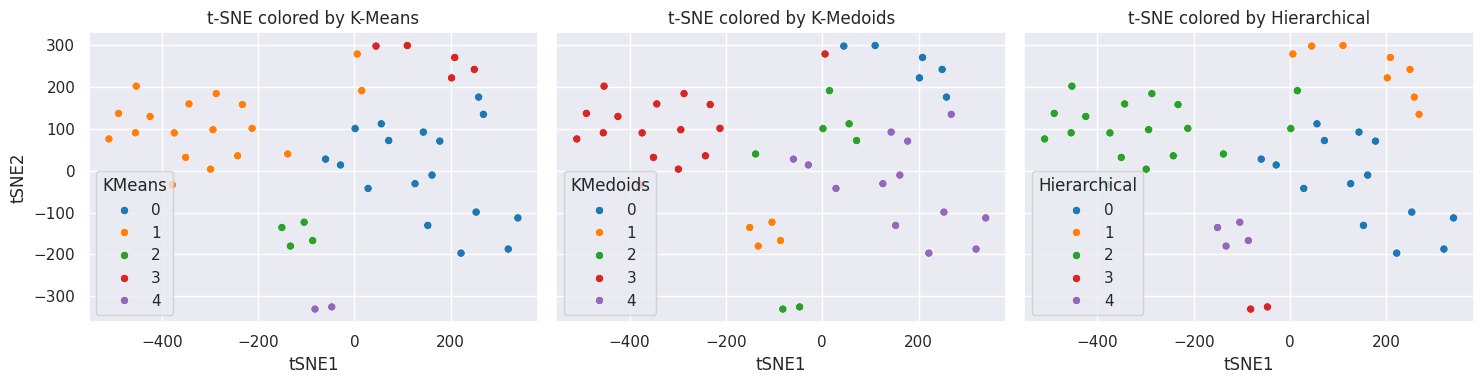

In [600]:
tsne_vis = tsne_df.copy()

tsne_vis["KMeans"] = kmeans_labels
tsne_vis["KMedoids"] = kmed_labels
tsne_vis["Hierarchical"] = hc_labels


fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

sns.scatterplot(
    data=tsne_vis, x="tSNE1", y="tSNE2",
    hue="KMeans", ax=axes[0], palette="tab10"
)
axes[0].set_title("t-SNE colored by K-Means")

sns.scatterplot(
    data=tsne_vis, x="tSNE1", y="tSNE2",
    hue="KMedoids", ax=axes[1], palette="tab10"
)
axes[1].set_title("t-SNE colored by K-Medoids")

sns.scatterplot(
    data=tsne_vis, x="tSNE1", y="tSNE2",
    hue="Hierarchical", ax=axes[2], palette="tab10"
)
axes[2].set_title("t-SNE colored by Hierarchical")

plt.tight_layout()
plt.show()


The side-by-side t-SNE visualizations color the same low-dimensional embedding using cluster assignments from each method.

The similar separation patterns across all three panels provide qualitative confirmation that K-means, K-medoids, and hierarchical clustering recover consistent structure in the data.


# **Conclusion**

This unsupervised analysis explored county-level energy composition patterns in Ohio using multiple clustering approaches; K-means, K-medoids, and hierarchical clustering.

Across all methods, a consistent set of energy-generation archetypes emerged, corresponding to coal-dominant, natural-gas–dominant, nuclear-dominant, renewables-dominant, and mixed-profile counties.

The agreement observed across clustering algorithms, supported by dendrogram structure, and cophenetic correlation, indicates that the identified patterns reflect stable structure in the data rather than artifacts of a particular method.

Overall, the results suggest that Ohio counties can be meaningfully segmented based on dominant energy-generation profiles, providing a compact and interpretable representation of heterogeneity in the state’s energy landscape.

These findings establish a foundation for further analysis, such as geographic interpretation, temporal dynamics, or policy-relevant comparisons across energy transition pathways.
